## Notes
- Specify dtype using memmap. Fml.

## Imports

In [1]:
import os
import numpy as np
import madmom as mm
import librosa as lr
import pretty_midi as pm
import matplotlib.pyplot as plt

## Constants

In [2]:
DATA_DIR = "../datasets/maps/CH/"
INPUT_NAME = "./inputs.dat"
EXPECT_NAME = "./expects.dat"

## Helpers

In [3]:
def log_filt(path):
    return  mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
        path,
        num_bands=48,
        num_channels=1, 
        sr=44100,
        unique_filters=True,
        norm_filters=True,
        frame_size=4096,
        fft_size=4096,
        fps=100,
        fmin=30,
        fmax=8000.0,
        fref=440.0,
        circular_shift=False,
        hop_size=441.0)

In [97]:
def save_mm(path, datapoint):
    mm_datapoint = np.memmap(
                        filename=path,
                        dtype='float32',
                        mode='w+',
                        shape=datapoint.shape)
    mm_datapoint[:] = datapoint[:]
    del mm_datapoint
    
def load_mm():
    NOTE_RANGE = 88
    N_BINS = 229

    mm_input = np.memmap(INPUT_NAME, 
                         mode='r',
                         dtype='float32'
                        )
    mm_output = np.memmap(EXPECT_NAME, 
                          mode='r',
                          dtype='float32'
                         )
    input = np.reshape(mm_input, (-1, N_BINS))
    output = np.reshape(mm_output, (-1, NOTE_RANGE))

    return input, output

## Load and Transform Samples

In [5]:
wavs = [d for d in os.listdir(DATA_DIR) if d.endswith('.wav')]

In [6]:
spects_and_expects = []
for w in wavs:
    wav_path = os.path.join(DATA_DIR, w)
    midi_path = os.path.join(DATA_DIR, w.replace('.wav', '.mid'))
    
    spect = lr.util.normalize(log_filt(wav_path))
    times = lr.frames_to_time(np.arange(spect.shape[0]), sr=44100, hop_length=441.0)
    midi = pm.PrettyMIDI(midi_path)
    expect = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
    expect[expect > 0] = 1
    
    spects_and_expects.append((spect, expect))

/anaconda2/lib/python2.7/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


## Visualize before and after save

In [7]:
spects = []
expects = []
for s, e in spects_and_expects:
    spects.append(s)
    expects.append(e)
    
#     fig = plt.figure(figsize=(50,7))
#     plt.grid()
#     plt.imshow(s.T ,aspect='auto')
#     plt.gca().invert_yaxis()
#     fig.axes[0].set_xlabel('time')
#     fig.axes[0].set_ylabel('frequency')
#     plt.show()
#     fig = plt.figure(figsize=(50,7))
#     plt.grid()
#     plt.imshow(e.T ,aspect='auto')
#     plt.gca().invert_yaxis()
#     fig.axes[0].set_xlabel('time')
#     fig.axes[0].set_ylabel('midi_notes')
#     plt.show()

spects = np.concatenate(spects)
expects = np.concatenate(expects)

#### Before

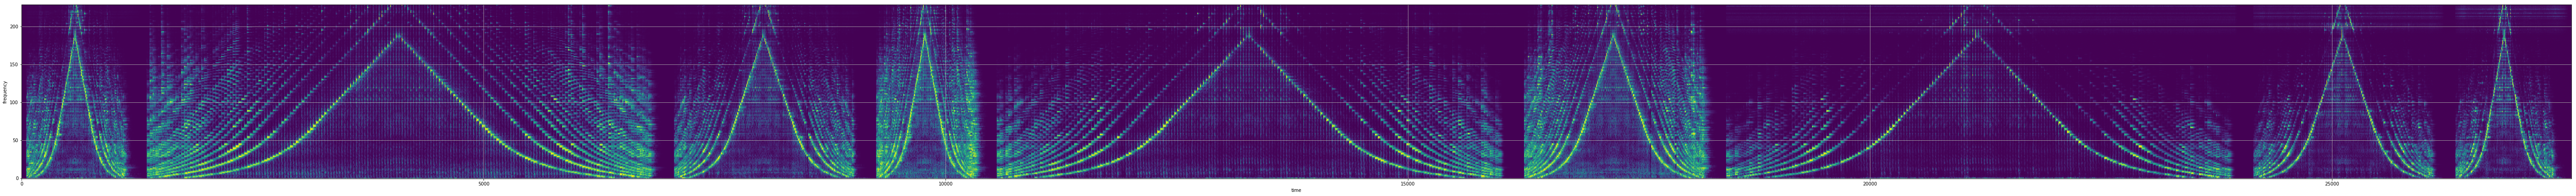

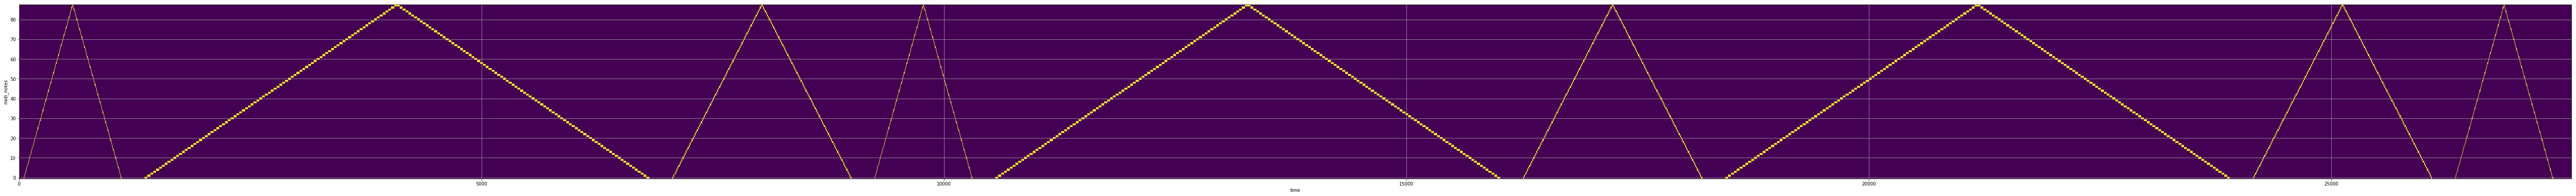

In [75]:
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(spects.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.show()
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(expects.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

#### Save and Load

In [87]:
save_mm(INPUT_NAME, spects)
save_mm(EXPECT_NAME, expects)
loaded_spects, loaded_expects = load_mm()

In [88]:
print loaded_spects.shape
print loaded_expects.shape

(27594, 229)
(27594, 88)


In [100]:
print spects.dtype
print loaded_spects.dtype
print spects.nbytes
print loaded_spects.nbytes

float64
float32
50552208
25276104


#### After

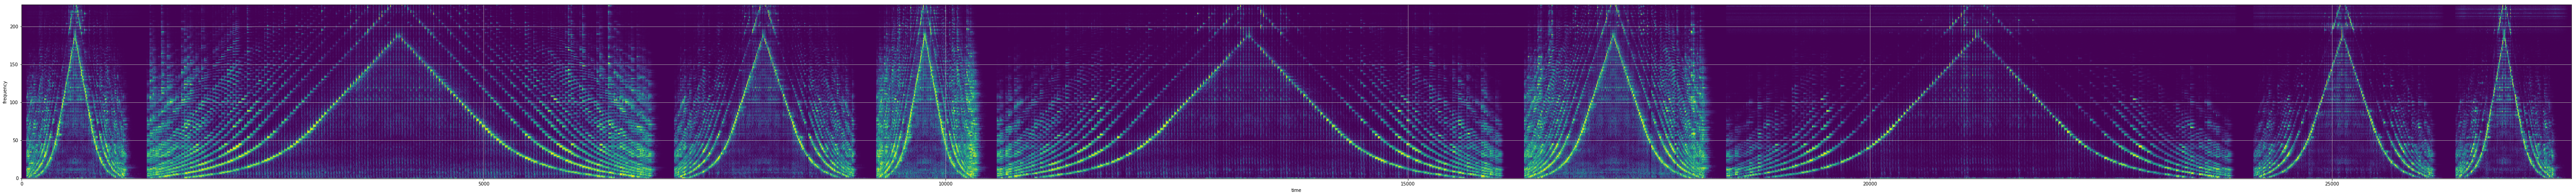

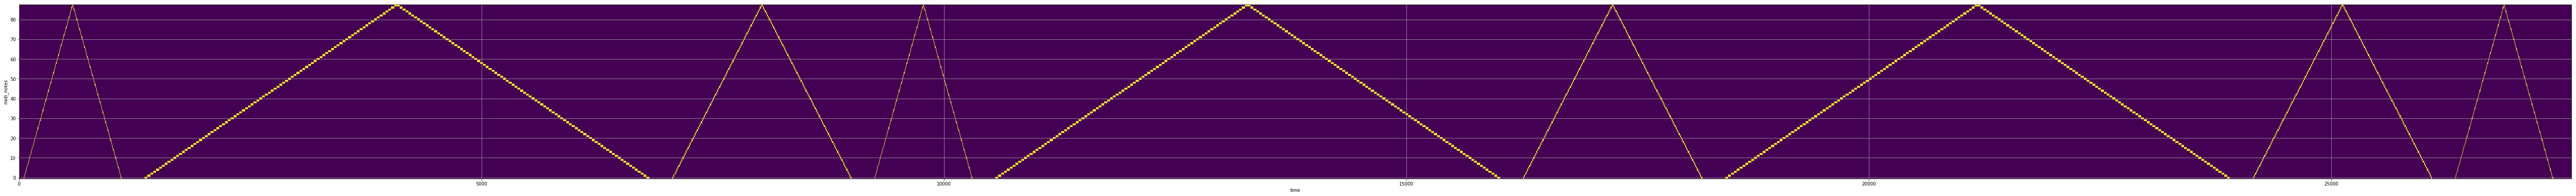

In [101]:
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(loaded_spects.T,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.show()
fig = plt.figure(figsize=(100,7))
plt.grid()
plt.imshow(loaded_expects.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

## Try librosa melspec

#### Double-check with pipeline code